(sec-dft)=
# Discrete Fourier Transform

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
from scipy.integrate import cumtrapz

dpi = 300
transparent = True
PI = np.pi
TWO_PI = 2*PI
NUM = 44000
show = False

sns.set_theme('paper')
sns.set_style("whitegrid")

def lineplot(x, y, filename=None, title=None, xlim=None, ylim=None, ax=None, fig=None, **kargs):
    if not ax or not fig:
        fig, ax = plt.subplots()
    ax.plot(x, y, **kargs)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if show:
        plt.show()
    if filename != None:
        fig.savefig(filename, bbox_inches='tight',
                    transparent=transparent, pad_inches=0, dpi=dpi)
    return fig, ax

Up to this point, we considered continuous signals $y(t)$.
In section [Fourier Series](sec-fourier), we started with **continuous periodic functions**.
We generalized this concept to **continuous aperiodic functions** in section [Fourier Transform](sec-fourier-transform).
That's all fine, but on a computer, we are not dealing with continuous functions.
On a computer, audio is digitalized.
That is, we are dealing with **discrete signals**.

## Definitions

To deal with a **periodic** and **discrete** signal, we switch from the *[Fourier transform](def-fourier-transform-exp)* to the *[discrete Fourier transform](def-discrete-fourier-transform)*.
If we want to handle a **non-periodic** and **discrete** signal, we apply the *discrete-time Fourier transform (DTFT)* instead.
For audio signals, the DTFT is not that relevant.

````{admonition} Discrete Fourier Series (DFS)
:name: def-fourier-series-exp-discrete
:class: definition

The *discrete Foruier series* $y: \mathbb{Z} \rightarrow \mathbb{C}$ in *exponential form* of a periodic and discrete function $y[n]$ is defined by

$$y[n] = \sum\limits_{k=0}^{N-1} c^*[k] \cdot e^{i\frac{2\pi}{N}kn}, \quad n \in \mathbb{Z},$$

which are harmonics of a fundamental frequency $1/N$, for some positive integer $N$ (the period of the signal).
````

This looks very similar to the [Fourier series](def-fourier-series-exp) except that $e^{ikn\frac{2\pi}{N}}$ is a discrete instead of a continuous function.
Instead of a sum of continuous functions, the *[discrete Fourier Series](def-fourier-series-exp-discrete)* is a sum of discrete functions.
Furthermore, there are only $N$ distinct coefficients $c^*[0], \ldots, c^*[N-1]$.
$y[n]$ is periodic and so is $c^*[k]$.

````{admonition} Discrete Fourier Transform (DFT)
:name: def-discrete-fourier-transform
:class: definition

The *discrete Foruier transform (DFT)* transforms of a sequence of $N$ *complex numbers* $y[0], \ldots, y[N-1]$ into another sequence of complex numbers $c[0], \ldots, c[N-1]$, such that

$$c[k] = \sum\limits_{n=0}^{N-1} y[n] \cdot e^{-i\frac{2\pi}{N}nk},$$

where $c[k]$ for $k = 0, \ldots, N-1$ are the coefficients of the *[discrete Fourier series](def-fourier-series-exp-discrete)*.
````

The DFT basically uses $N$ probing functions defined by the [phasors](def-phasor) $\hat{1}_{-2 \pi k / N}, k = 0, \ldots, N-1$ to analyse the discrete signal $y$ for frequencies 

$$0, \frac{1}{N}, \ldots, \frac{N-1}{N}$$

times the *sample frequency* $f_s$. However, due to the [Nyquist–Shannon sampling theorem](theorem-sampling) we can only rely on the first half of coefficients, i.e.,

$$0, \frac{f_s}{N}, \ldots, \frac{f_s}{2}.$$

Also, note that the DFT does only probe for frequencies that are an integer multiple of the fundamental frequency 

$$\frac{f_s}{N}.$$

Therefore, we expect limitations when dealing with inharmonic content because any content within the signal which is not part of some harmonic will be approximated by those harmonics and since we only compute a finite number of coefficients, this approximation is imperfect.

Similar to the *[Fourier transform](def-fourier-transform-exp)* there is an inverse transformation.

````{admonition} Inverse Discrete Fourier Transform (IDFT)
:name: def-inverse-discrete-fourier-transform
:class: definition

The *inverse discrete Fourier transform IDFT* transforms a sequence of $N$ *complex numbers* $c[0], \ldots, c[N-1]$ into another sequence of complex numbers  $y[0], \ldots, y[N-1]$, such that 

$$y[n] = \frac{1}{N} \sum\limits_{k=0}^{N-1} c[k] \cdot e^{i\frac{2\pi}{N}kn},$$

where $c[k]$ for $k = 0, \ldots, N-1$ are the coefficients of the *[discrete Fourier transform](def-discrete-fourier-transform)*.
````

Note that the *[inverse discrete Fourier transform  IDFT](def-inverse-discrete-fourier-transform)* is a specific examle of a *[discrete Fourier series](def-fourier-series-exp-discrete)*.

## Example

Suppose the following signal is given

$$y(t) = \underbrace{5}_{\text{DC}} + \underbrace{2 \cos(2\pi t - \pi/2)}_{\text{1 Hz}} + \underbrace{3 \cdot \cos(4\pi t)}_{\text{2 Hz}}.$$

Let's sample $y(t)$ at 4 times per second, i.e. a *sample rate* $f_s$ of 4 Hz from $t = 0$ to $t=3/2$.
The values of the discrete samples are given by:

$$y[n] = 5 + 2 \cos(\pi/3 n - \pi/2) + 3 \cos(\pi n)$$

for $t = n / 4$.
We get $y[0] = 8$, $y[1] = 4$, $y[2] = 8$, $y[3] = 0$, $y[4] = y[0]$, ...
Clearly $N = 4$ since we have frequencies of 1 and 2 Hz and a sample frequency $f_s$ of 4 Hz.

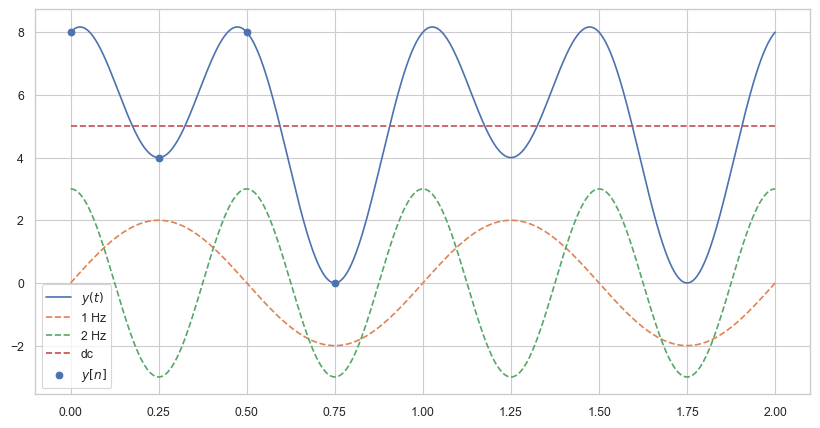

In [2]:
y1 = lambda t: 2 * np.cos(2*np.pi*t - np.pi/2)
y2 = lambda t: 3 * np.cos(4*np.pi*t)
dc = lambda t: np.ones(len(t))*5
y = lambda t: dc(t) + y1(t) + y2(t)

t = np.linspace(0, 2, 1000)
n = np.linspace(0, 1, 5)[:-1]
y_n = y(n)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, y(t), label=r'$y(t)$')
ax.plot(t, y1(t), label=r'1 Hz', linestyle='--')
ax.plot(t, y2(t), label=r'2 Hz', linestyle='--')
ax.plot(t, dc(t), label=r'dc', linestyle='--')
ax.scatter(n, y_n, label=r'$y[n]$', marker='o')
fig = ax.legend()

Let us implement the *DFT* and *IDFT* using ``Python``.
The following code is inefficient but suffice for our purposes.

### DFT

```isc
(
~dft = {arg y, k;
    var m = y.size, result = 0;
    for(0, m-1, {
        arg n;
        result = result + (y[n] * exp(Complex(0,-1) * 2 * pi / m * n * k));
    });
    result;
};
)
```

```isc
y = [8, 4, 8, 0];
c = Array.fill(y.size, {arg i; i}).collect({arg i; ~dft.(y, i)});

/* [ 
Complex( 20.0, 0.0 ), 
Complex( 0.0, -4.0 ), 
Complex( 12.0, 1.4695761589768e-15 ), 
Complex( -8.8817841970013e-16, 4.0 ) ]
*/

```

In [3]:
def dft(y, k):
    N = len(y)
    result = 0
    for n in range(N):
        result += y[n] * np.exp(-1j * 2*np.pi/N * n * k)
    return result

In [4]:
c_k = [dft(y_n, k) for k in range(len(y_n))]

``c_k`` contains the values of our coefficients, i.e. $c[k]$ for $k = 0, 1, 2, 3$ **Hz**, i.e.,

$$c[0] = 20, c[1] = -4i, c[2] = 12, c[3] = +4i.$$

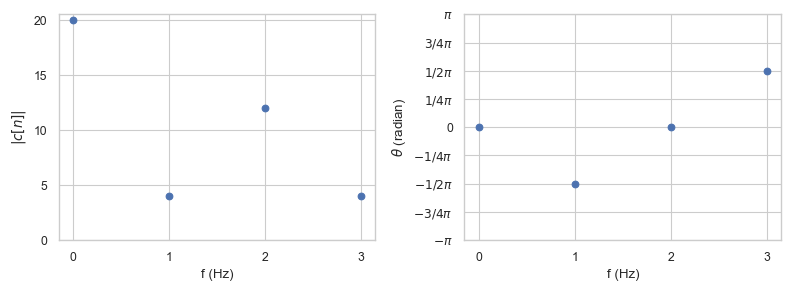

In [5]:
fig, ax = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
f = np.array([0, 1, 2, 3])
ax[0].scatter(f, np.abs(np.array(c_k)), label=r'$|c[n]|$')
ax[0].set_ylim((0,20.5))
ax[0].set_xticks(f)
ax[0].set_yticks([0, 5, 10, 15, 20])
ax[0].set_xlabel(r'f (Hz)')
ax[0].set_ylabel(r'$|c[n]|$');

ax[1].scatter(f, np.arctan2([val.imag for val in c_k], [val.real for val in c_k]), label=r'$|c[n]|$')
ax[1].set_ylim((-np.pi,np.pi))
ax[1].set_xticks(f)
ax[1].set_yticks([-np.pi, -3/4 * np.pi, -1/2*np.pi, -1/4*np.pi, 0, 1/4*np.pi, 1/2*np.pi, 3/4 * np.pi, np.pi])
ax[1].set_yticklabels([r'$-\pi$',r'$-3/4\pi$', r'$-1/2 \pi$', r'$-1/4 \pi$', r'0', r'$1/4 \pi$', r'$1/2 \pi$', r'$3/4 \pi$', r'$\pi$'])
ax[1].set_xlabel(r'f (Hz)')
ax[1].set_ylabel(r'$\theta$ (radian)');
plt.tight_layout()

Since we have 4 samples, i.e., $N=4$, we have to divide by 4 to compute the respective amplitudes.
Since $y(t)$ is a real-valued function we already know that

$$c[n] \equiv \overline{c[N-n]}.$$

and the amplitude is given by 

$$\frac{2}{N} \cdot c[n], \text{ if there is another } c[N-n] $$

otherwise it is

$$\frac{1}{N} \cdot c[n]$$

Furthermore, because of *[Nyquist–Shannon sampling theorem](theorem-sampling)*, we can not compute the amplitude (and phase) of frequencies greater than 2 Hz.
In general, all $c[n]$ with $n > \frac{N}{2}$ are **invalid** because of *[aliasing](def-aliasing)*.
Therefore, $c[3] = 4i$ is ''incorrect''.
We can not distinguish the sinusoid of frequency $1$ from the sinusoid of frequency $3 = 1 + f_s$.
Therefore, 

$$c[1] = 2 \cdot 4i = 8i.$$

In summary, we get

$$A_0 = \frac{1}{N} c[0] = \frac{20}{4} = 5, \quad A_1 = \frac{2}{4} c[1] = \frac{8}{4} = 2, \quad A_2 = \frac{1}{4} c[2] = \frac{12}{4} = 3.$$

Furthermore, **we can perfectly reconstruct the original continuous harmonic signal** $y(t)$!

Now you might wonder what happened to the [complex number](sec-complex-numbers) $c[1] = -4i$?
Remember, multiplying by $i$ equates to a counterclockwise rotation by 90 degrees.
The ''cosine-part'' of the complex number represents the real part.
Therefore, the **phase** of the cosine with the fundamental frequency is shifted by $-\pi/2$.
Which is true for $y(t)$.

### IDFT

Let's now apply the IDFT:

```isc
(
~idft = {arg y, k;
    var m = y.size, result = 0;
    for(0, m-1, {
        arg n;
        result = result + (y[n] * exp(Complex(0,1) * 2 * pi / m * n * k));
    });
    result / m;
};
)
```

```isc
~iy = Array.fill(c.size, {arg i; i}).collect({arg i; ~idft.(c, i)});

/* [ 
Complex( 8.0, -6.6613381477509e-16 ), 
Complex( 4.0, -2.2884754904439e-17 ), 
Complex( 8.0, 6.6613381477509e-16 ), 
Complex( 7.7715611723761e-16, 1.2475315540518e-15 ) ]
 */
```

In [6]:
def idft(c, n):
    N = len(c)
    result = 0
    for k in range(N):
        result += c[k] * np.exp(1j * 2*np.pi/N * k * n)
    return 1/N * result

In [7]:
iy_n = [idft(c_k, n) for n in range(len(c_k))]

If we neglect the small numerical errors, we get the correct function values $y[n]$ for $n = 0, 1, 2, 3$ back again.
The imaginary part of the complex numbers is approximately zero because $y(t)$ is a real-valued function.

## Limitations

Let us suppose we have the following signal consisting of only one frequency:

$$y(t) = \sin\left(f \cdot 2 \pi \frac{n}{N} \right),$$

where $N = 16$ and $f = 3/4$.
If the fundamental analysis period of the DFT is also $N = 16$, i.e., the sampling frequency $f_s$ is $1$ Herz and the fundamental analysis frequency $f_N$ is 1/16 Herz, then $f = 3/4$ is clearly not an integer multiple of the sampling frequency! 

The following plot shows the actual signal $y(t)$ and the discontinuous signal $y_{\text{dft}}(t)$ 'seen / assumed' by the DFT operation.
Computing the IDFT gives us the correct sample points, i.e., $y[n] \equiv y_\text{dft}[n]$ holds, but the reconstructed signal $y_\text{idft}(t)$ is incorrect.

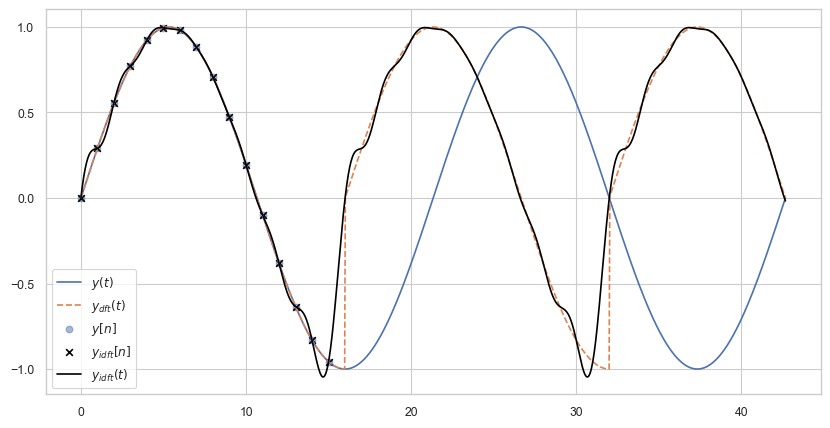

In [8]:
N = 16
f = 3/4
f_s = 1/N
y_f = lambda k, t: np.sin(k/N * 2 * np.pi * t)
y_one = lambda t: 14/N * np.cos(1/N * 2 * np.pi * t + 2.16259125)
    
y = lambda t: np.sin(f * 2 *np.pi * t / N)
y2 = lambda t: np.sin(f * 2 * np.pi * (t%16) / N)
t = np.linspace(0, 2*N*4/3, 1000)
t2 = np.linspace(0, N, 1000)
n = np.linspace(0, N, N+1)[:-1]

y_n = y(n)
c_k = [dft(y_n, k) for k in range(len(y_n))]

iy_n = [idft(c_k, n) for n in range(len(c_k))]
iy_n = [val.real for val in iy_n]

phases = np.arctan2([val.imag for val in c_k], [val.real for val in c_k])
magnitudes = np.abs(np.array(c_k))

def idft_fuction(t):
    s = 0
    for i in range(len(magnitudes)//2):
        if i == 0:
            s += (1/N * magnitudes[-i]) * np.cos(i/N * 2 * np.pi * t + phases[i])
        else:
            s += (1/N * magnitudes[i] + 1/N * magnitudes[-i]) * np.cos(i/N * 2 * np.pi * t + phases[i])
    
    i = len(magnitudes)//2
    s +=  (1/N * magnitudes[-i]) * np.cos(i/N * 2 * np.pi * t + phases[i])
    return s

y_idft = [idft_fuction(ti) for ti in t]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, y(t), label=r'$y(t)$')
ax.plot(t, y2(t), label=r'$y_{dft}(t)$', linestyle='--')
ax.scatter(n, y(n), label=r'$y[n]$', marker='o', alpha=0.5)
ax.scatter(n, iy_n, label=r'$y_{idft}[n]$', marker='x', c='black')
ax.plot(t, y_idft, label=r'$y_{idft}(t)$', c='black')
ax.legend();

Computing the IDFT gives us the correct values for our samples but if we look at the frequency and phase spectrum we can observe many different frequencies that are present:

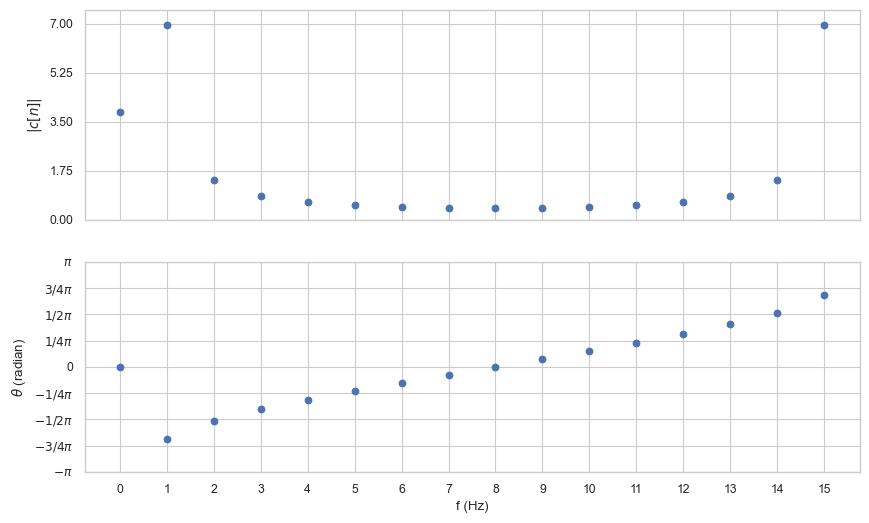

In [9]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2, ncols=1, sharex=True)
f = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
ax[0].scatter(f, np.abs(np.array(c_k)), label=r'$|c[n]|$')
ax[0].set_ylim((0,7.5))
ax[0].set_xticks(f)
ax[0].set_yticks([0, 3.5/2, 3.5, 3.5+3.5/2, 7])
ax[0].set_ylabel(r'$|c[n]|$')
ax[1].scatter(f, np.arctan2([val.imag for val in c_k], [val.real for val in c_k]), label=r'$|c[n]|$')
ax[1].set_ylim((-np.pi,np.pi))
ax[1].set_xticks(f)
ax[1].set_yticks([-np.pi, -3/4 * np.pi, -1/2*np.pi, -1/4*np.pi, 0, 1/4*np.pi, 1/2*np.pi, 3/4 * np.pi, np.pi])
ax[1].set_yticklabels([r'$-\pi$',r'$-3/4\pi$', r'$-1/2 \pi$', r'$-1/4 \pi$', r'0', r'$1/4 \pi$', r'$1/2 \pi$', r'$3/4 \pi$', r'$\pi$'])
ax[1].set_xlabel(r'f (Hz)')
ax[1].set_ylabel(r'$\theta$ (radian)');

There are actually two problems here:

+ *Picket fence effect*: We are trying to represent a frequency $(3/4 \cdot 1/16)$ that is not an integer multiple of the fundamental analysis frequency $f_N = 1/16$, so the results do not fit appropriately as harmonics of $f_N$. We cannot view the underlying continuous spectrum because the DFT limits us to integer multiples of the fundamental analysis frequency $f_N$. This is analogous to observing a row of evenly spaced trees through a picket fence.
+ *Leakage*: Discontinuities at the edge of the analysis window spray noise throughout the rest of the spectrum. This phenomenon is called *leakage* because the energy that should be in one spectral harmonic spreads away (leaks) into adjacent harmonics.

To reduce the picket fence effect, we can increase the spectral frequency resolution by artificially increasing the number of samples, e.g., by padding them with zeros.
The leakage problem is more serious.
The best we can do is devise a workaround.
We create a function exactly as long as the analysis window gradually fades in and fades out at the edges.
If we multiply the signal to be analyzed by this function (which is called *windowing*), we decrease the effect of any discontinuities at the edges of the analysis window because the discontinuities are heavily attenuated at the analysis window edges.
This helps to reduce the impact, but there is no free lunch because any alternation of the input signal will have some effect on the resulting spectrum.


## Fast Fourier Transform

The *fast Fourier rransform (FFT)* is an algorithm that computes the *discrete Fourier transform (DFT)* of a sequence, or its inverse. 
Fourier analysis converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa.

The FFT is an efficient way to compute the DFT. 
It is a *divide-and-conquer algorithm* that recursively breaks down a DFT of any composite size (a power of 2) into many smaller DFTs.
This significantly reduces the computational complexity from quadratic $\mathcal{O}(n^2)$ to almost linear $\mathcal{O}(n \log(n))$, which makes it much faster for large sequences.

Let me give you a simplified version of how the *Cooley-Tukey radix-2 decimation in time (DIT) FFT* {cite}`cooley:1965` works.
It is one of the most commonly used FFT algorithms.

The algorithm first divides the discrete input signal into two parts: one for even-indexed points and one for odd-indexed points.
It computes the DFTs of these two parts recursively.
Because the index difference for the odd and even parts is twice as big, half as many points are needed for each DFT, which reduces the computation.
The results of the two smaller DFTs are combined into the DFT of the whole signal using a formula called the *butterfly operation*.
The process is repeated until all DFTs are computed.

For more details I refer to the original publication.

## Short-Time Fourier Transform

The Fourier transform yields frequency information that is averaged over the entire time domain.
Therefore, the information *when* these frequencies occur is hidden in the transform.
For instance, if we have the following signal, and we take the transform, there is no way to tell that the signal's frequency changed at a certain point in time (here it would be after 1 second).

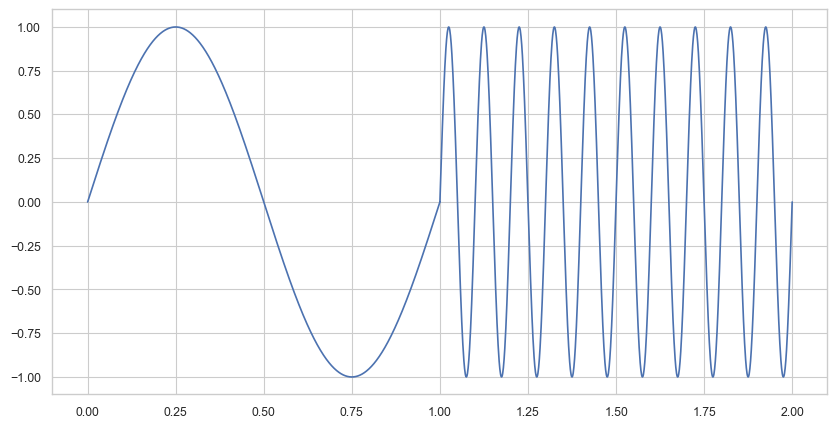

In [10]:
t1=np.linspace(0,1,1000)
t2=np.linspace(1,2,1000)
y1=np.sin(2*np.pi*t1)
y2=np.sin(10*2*np.pi*t2)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.concatenate((t1,t2)),np.concatenate((y1,y2)));

To recover the hidden time information, Dennis Gabor introduced in 1946, the short-time Fourier transform (STFT).
Instead of considering the entire signal, the main idea of the STFT is to consider only a small section of the signal.
To this end, one fixes a so-called *window function*, which is a function that is nonzero for only a short period of time (defining the considered section).
The original signal is then multiplied with that *window function* to get a *windowed signal*.
Then we take the Fourier transform of that windowed signal!

To obtain frequency information at different time instances, one shifts the *window function* across time and computes a Fourier transform for each of the resulting *windowed singals*.

Similar to the measurement processes in quantum physics, there's an important and rather conspicuous trade-off: it is impossible to measure all frequencies at all times. If we aim for precise timing, we must choose a small ``windowsize``, consequently losing precision in the measured frequencies, meaning we lose low-frequency information. 
Conversely, if the ``windowsize`` is large, we sacrifice precision in time.

Often one defines a so called *hop distance* or ``hop`` which indicates how far two consecutive windows are apart.
Usually windows overlap.

Furthermore, one can use different *window functions* (``wintype``).
SuperCollider supports **rectangular** ``-1`` windowing (simple but typically not recommended), **sine** ``0`` (default) windowing (typically recommended for phase-vocoder work), or **Hann** windowing ``1`` (typically recommended for analysis work).
The **Hann** window looks like a *Gaussian bell*.
Compared to the **sine** window, it has an exponential increase and decay, i.e., looks slimmer.


## FFT in SuperCollider

To compute the DFT and IDFT using the FFT algorithm in [SuperCollider (SC)](https://supercollider.github.io/), we use the unit generators [FFT](https://doc.sccode.org/Classes/FFT.html) and [IFFT](https://doc.sccode.org/Classes/IFFT.html), respectively.
And because the fast Fourier transform algorithm is so efficient, we can do it in real time!
Therefore, we "work" in frequency space by

1. Transforming the signal into the frequency space using the [FFT](https://doc.sccode.org/Classes/FFT.html) unit generator
2. Manipulating the coefficients as we desire
3. Transforming the signal back to the time domain using the [IFFT](https://doc.sccode.org/Classes/IFFT.html) unit generator

````{admonition} FFT and IFFT Buffers
:name: attention-fft-ifft-sc
:class: attention

[FFT](https://doc.sccode.org/Classes/FFT.html) and [IFFT](https://doc.sccode.org/Classes/IFFT.html) unit generators require a buffer to store the frequency-domain data. 
This buffer must have exactly **one** channel. 
Multichannel buffers are never supported.

To do [FFT](https://doc.sccode.org/Classes/FFT.html) processing on a multichannel signal, provide an array of mono buffers, one for each channel. 
Then, [FFT](https://doc.sccode.org/Classes/FFT.html)/[IFFT](https://doc.sccode.org/Classes/IFFT.html) will perform [multichannel expansion](sec-mce), to process each channel separately.
````

The following example has no effect on the input 'in' since we merely transform the signal and then promptly revert it.

```isc
(
{
    var in, out, chain, freq = 200;
    in = SinOsc.ar(freq);

    chain = FFT(
        buffer: LocalBuf(2048), 
        in: in, 
        hop: 0.5, // offset of te next FFT, rnages from > 0 to <= 1.
        wintype: 0, // -1 triangle, 0 sine, 1 Hann
        active: 1, // 1 active, <= 0 inactive
        winsize: 0 // 0 => equal to the buffer
    ); 	

    // here we could manipulate the coefficients
    chain.inspect; 
    out = IFFT(chain); // inverse FFT
    out;
}.play;
)
```